# Introduction

## Import libraries

In [2]:
%matplotlib inline

import pandas as pd
import datetime 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import glob
import os
import getpass
import sqlalchemy
#import geoalchemy2
import sys
import itertools

import peakutils

import statsmodels.api as sm
from scipy.fftpack import fft

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.stattools import durbin_watson
#from sklearn.linear_model import LinearRegression, LassoLars, lars_path, lasso_path
#from sklearn.preprocessing import normalize
from statsmodels.tsa.arima_model import ARIMA

from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm


from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

#from shutil import copyfile
import pastas as ps

import io
import requests

import platform
from matplotlib import rcParams

import folium

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot,iplot_mpl,plot_mpl
import plotly.graph_objs as go

init_notebook_mode(connected=True)

from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import geopandas as gpd

import wellapplication as wa

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression, LassoLars, lars_path, lasso_path
from sklearn.preprocessing import normalize
from statsmodels.tsa.arima_model import ARIMA


rcParams['figure.figsize'] = 15, 10
rcParams['pdf.fonttype'] = 42

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:70: MatplotlibDeprecationWarning:


The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.



## Database Connection

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("dbconnect", "G:/My Drive/Python/dbconnect.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)
engine = dbconnect.postconn_leland(port=5433)

engine2 = dbconnect.postconn(port=5433)

## File Locations

In [4]:
file_place = "G:/My Drive/WORK/Leland_Harris/intermediate/"

# Import Local Station Data

In [5]:
ugs_climate_dir = "G:/My Drive/WORK/Leland_Harris/climate_data/UGS_Station/"
ugs_climate_loc_0 = ugs_climate_dir + "UGS_Snake_Valley_Weather_Station_0.csv"
ugs_climate_loc_1 = ugs_climate_dir + "UGS_Snake_Valley_Weather_Station_1.csv"


ugs_clim_raw_0 = pd.read_csv(ugs_climate_loc_0, skiprows=1)
ugs_clim_raw_1 = pd.read_csv(ugs_climate_loc_1, skiprows=1)
ugs_clim_raw = pd.concat([ugs_clim_raw_0,ugs_clim_raw_1])
ugs_clim_raw.index = pd.to_datetime(ugs_clim_raw['Date Time, GMT-07:00'])
ugs_clim_raw.index = ugs_clim_raw.index.tz_localize('MST')


C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




# Penman-Monteith ET Estimate

http://edis.ifas.ufl.edu/pdffiles/ae/ae45900.pdf<br>
http://onlinecalc.sdsu.edu/<br>
http://www.fao.org/3/X0490E/x0490e07.htm

## Step 1 - Temp

In [63]:

ugs_clim_raw = ugs_clim_raw.tz_localize(None)

locclim = {'#':'numb', 
           'Date Time, GMT-07:00':'datetime',
           'Temp, °F (LGR S/N: 20077753, SEN S/N: 10869187, LBL: AirTemperature)':'air_temp',
           'RH, % (LGR S/N: 20077753, SEN S/N: 10869187, LBL: Humidity)':'RH',
           'Water Content, m³/m³ (LGR S/N: 20077753, SEN S/N: 10881810, LBL: Soil Moisture)':'soil_moisture',
           'Temp, °F (LGR S/N: 20077753, SEN S/N: 10883570, LBL: Soil Temp)':'soil_temp',
           'Rain, in (LGR S/N: 20077753, SEN S/N: 20067089, LBL: Precip)':'precip',
           'PAR, µmol/m²/s (LGR S/N: 20077753, SEN S/N: 20082571, LBL: PAR1)':'PAR1',
           'PAR, µmol/m²/s (LGR S/N: 20077753, SEN S/N: 20082572, LBL: PAR2)':'PAR2',
           'Solar Radiation, W/m² (LGR S/N: 20077753, SEN S/N: 20089743, LBL: SolarRadiation1)':'SolarRadiation1',
           'Solar Radiation, W/m² (LGR S/N: 20077753, SEN S/N: 20089744, LBL: SolarRadiation2)':'SolarRadiation2',
           'Pressure, in Hg (LGR S/N: 20077753, SEN S/N: 20093399, LBL: BarometricPressure)':'BaroPressure',
           'Wind Speed, mph (LGR S/N: 20077753, SEN S/N: 20096052, LBL: Wind Speed)':'Wind_Speed',
           'Gust Speed, mph (LGR S/N: 20077753, SEN S/N: 20096052, LBL: Gust Speed)':'Gust_Speed',
           'Wind Direction, ø (LGR S/N: 20077753, SEN S/N: 20096052, LBL: Wind Direction)':'Wind_Direction',
           'DewPt, °F (LGR S/N: 20077753, SEN S/N: 10869187)':'DewPt'}
ugs_clim_raw = ugs_clim_raw.rename(columns=locclim)
ugs_clim_raw['air_temp_c'] = ugs_clim_raw['air_temp'].apply(lambda x: (x - 32.0)*(5/9),1)
ugs_clim_raw['dewpt_c'] = ugs_clim_raw['DewPt'].apply(lambda x: (x - 32.0)*(5/9),1)
ugs_clim_raw_dly = ugs_clim_raw.groupby(pd.Grouper(freq='1D')).mean()
ugs_clim_raw_dly['precip'] = ugs_clim_raw['precip'].resample('1D').sum()
ugs_clim_raw_dly['max_dly_temp'] = ugs_clim_raw.groupby(pd.Grouper(freq='1D'))['air_temp_c'].max()
ugs_clim_raw_dly['min_dly_temp'] = ugs_clim_raw.groupby(pd.Grouper(freq='1D'))['air_temp_c'].min()
ugs_clim_raw_dly['mean_dly_temp'] = ugs_clim_raw.groupby(pd.Grouper(freq='1D'))['air_temp_c'].mean()
ugs_clim_raw_dly['tmean'] = (ugs_clim_raw_dly['max_dly_temp'] + ugs_clim_raw_dly['min_dly_temp'])/2

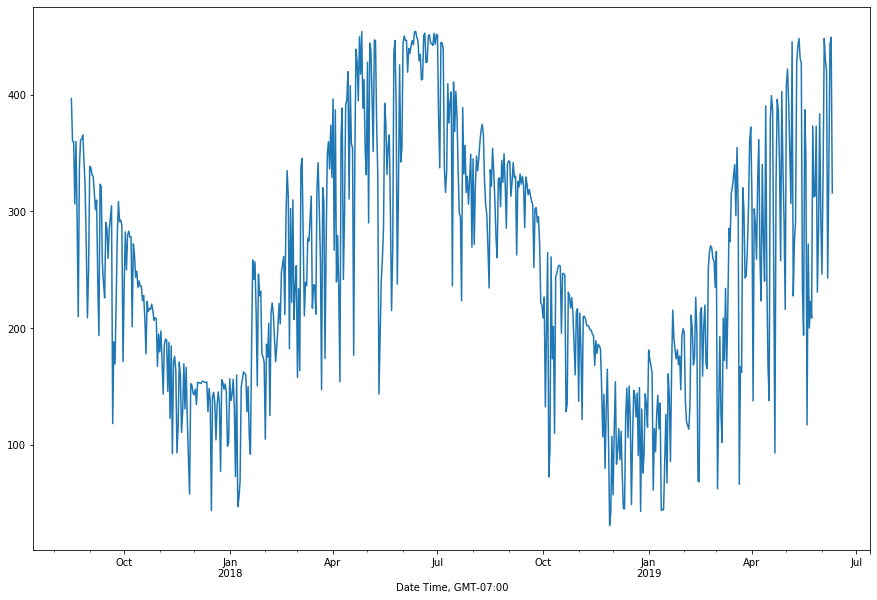

In [8]:
ugs_clim_raw[['PAR1','PAR2']].mean(axis=1).resample('1D').mean().plot()

## Step 2 - Solar Radiation

In [9]:
ugs_clim_raw_dly['solar_rad'] = ugs_clim_raw[['SolarRadiation1','SolarRadiation2']].mean(axis=1).groupby(pd.Grouper(freq='1D')).mean()*0.0864 # convert to MJ per square meter per day

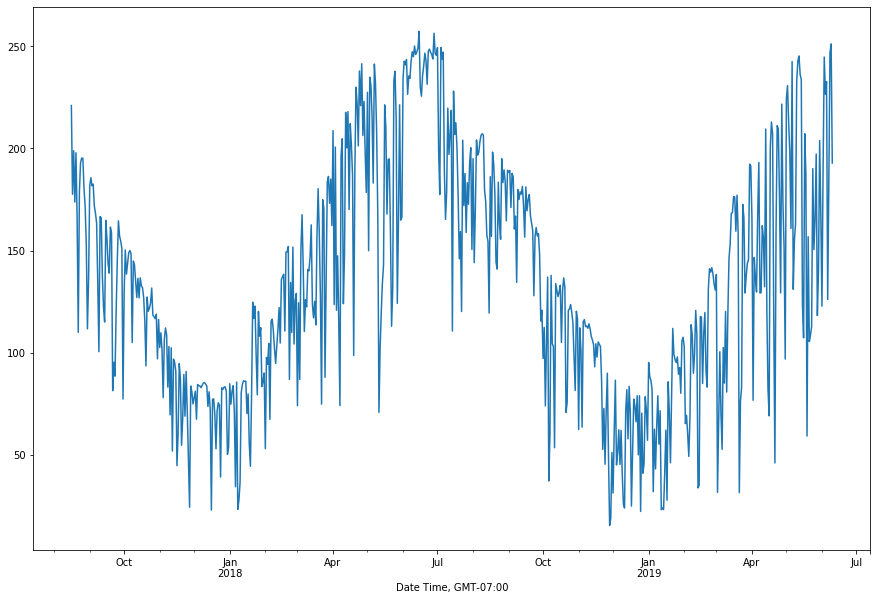

In [7]:
ugs_clim_raw[['SolarRadiation1','SolarRadiation2']].mean(axis=1).resample('1D').mean().plot()

## Step 3 - Wind Speed

In [10]:
uh = ugs_clim_raw['Wind_Speed']*0.447
# uh wind speed data m/s at a hieght h other than 2 meters
h = 2.5 # height of aneomometer
u2 = uh*(4.87/np.log(67.8*h - 5.42))
ugs_clim_raw_dly['u2_wind'] = u2.groupby(pd.Grouper(freq='1D')).mean()

## Step 4 - Slope of saturation vapor pressure curve

https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf<br>
http://ww2010.atmos.uiuc.edu/(Gh)/guides/mtr/cld/dvlp/rh.rxml

In [11]:
def vsat(x):
    return (0.6108*np.exp((17.27*x)/(x + 237.3)))

def vsatslp(x):
    es = vsat(x)
    return 4098*es/(x + 237.3)**2

([<matplotlib.axis.YTick at 0x265876c07f0>,
 <a list of 21 Text yticklabel objects>)

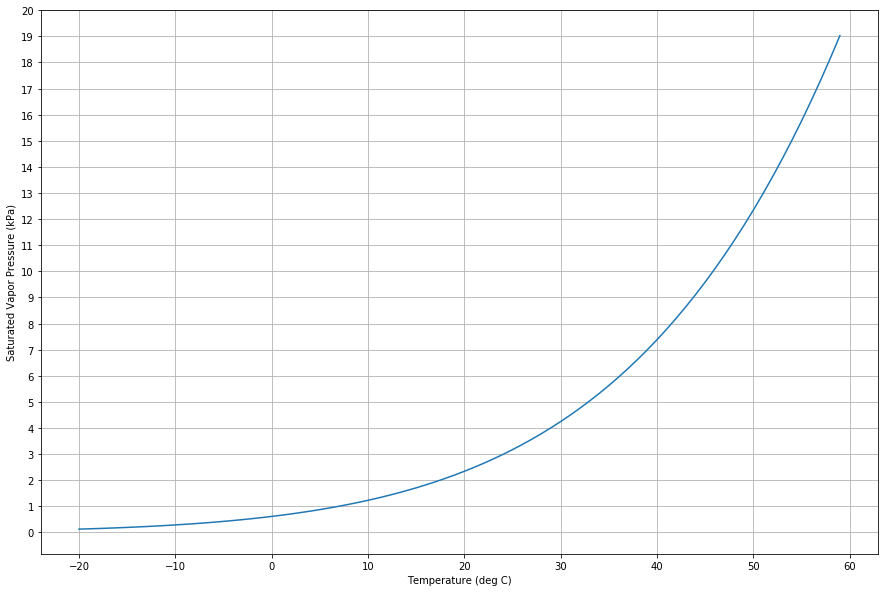

In [12]:
T = range(-20, 60)
es = [vsat(i) for i in T] # saturated vapor pressure in millibars (hectoPascals)
plt.plot(T,es)
plt.grid()
plt.xlabel('Temperature (deg C)')
plt.ylabel('Saturated Vapor Pressure (kPa)')
plt.yticks(range(0,21,1))

Text(0, 0.5, 'saturated vapor pressure (kPa)')

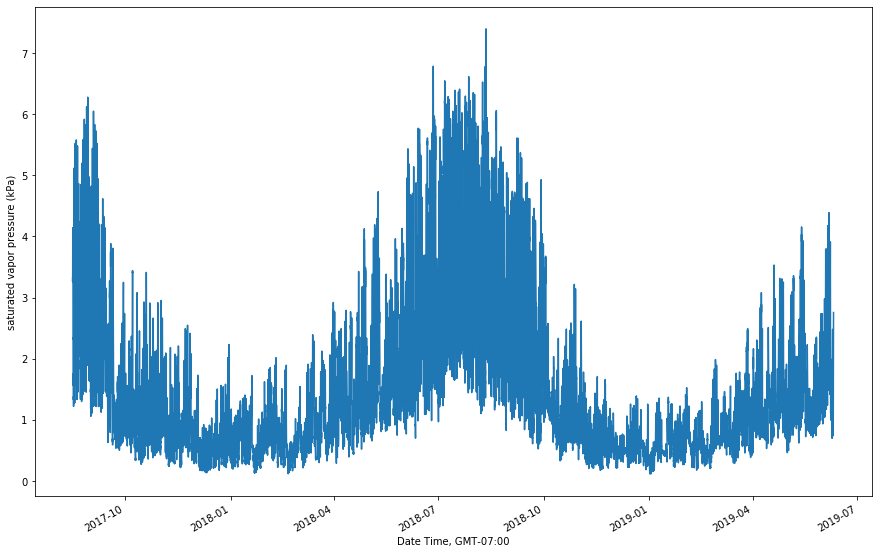

In [13]:
ugs_clim_raw['sat_vap_press'] = ugs_clim_raw['air_temp_c'].apply(lambda x: vsat(x),1)
ugs_clim_raw['sat_vap_press'].plot()
plt.ylabel('saturated vapor pressure (kPa)')

In [36]:
esslope = ugs_clim_raw['air_temp_c'].apply(lambda x: vsatslp(x),1)
ugs_clim_raw_dly['esslope'] = esslope.groupby(pd.Grouper(freq='1D')).mean()

## Step 5 – Atmospheric Pressure

Convert inches of Hg to kPa by multiplying by 3.38639

In [37]:
ugs_clim_raw_dly['atm_press'] = ugs_clim_raw['BaroPressure'].groupby(pd.Grouper(freq='1D')).mean()*3.38639

## Step 6 – Psychrometric constant

In [38]:
ugs_clim_raw_dly['psy_const'] = ugs_clim_raw_dly['atm_press']*0.000665

## Step 7 – Delta Term

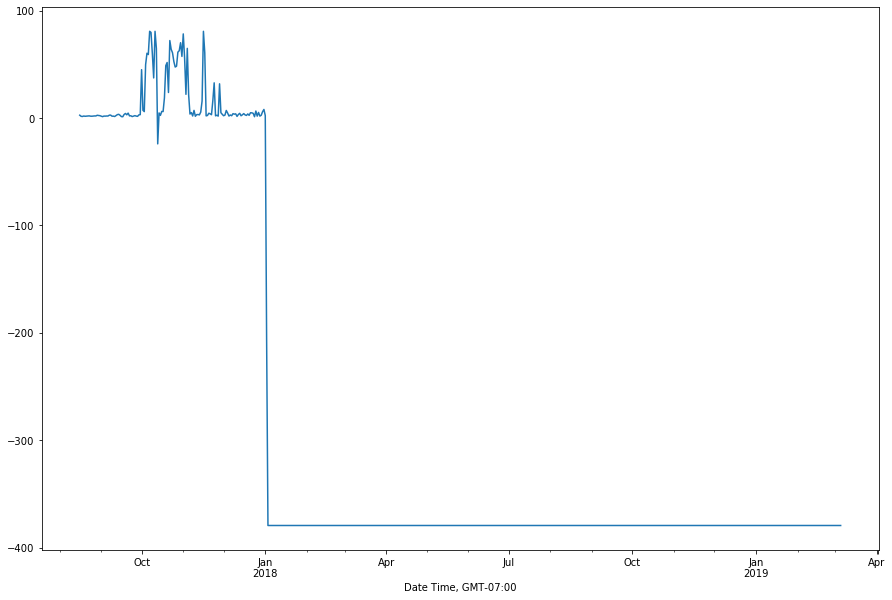

In [39]:
ugs_clim_raw_dly['u2_wind'].plot()

In [40]:
ugs_clim_raw_dly['delta'] = ugs_clim_raw_dly[['esslope',
                                              'psy_const',
                                              'u2_wind']].apply(lambda x: x[0]/(x[0]+x[1]*(1+0.34*x[2])),1)

## Step 8 - Psi Term

In [41]:
ugs_clim_raw_dly['psi'] = ugs_clim_raw_dly[['esslope',
                                              'psy_const',
                                              'u2_wind']].apply(lambda x: x[1]/(x[0]+x[1]*(1+0.34*x[2])),1)

## Step 9 - TT

In [42]:
ugs_clim_raw_dly['TT'] = ugs_clim_raw_dly[['tmean','u2_wind']].apply(lambda x: (900.0/(x[0]+273))*x[1],1)

## Step 10 - Mean Saturation Vapor Pressure

In [43]:
ugs_clim_raw_dly['sat_vap_press'] = ugs_clim_raw['sat_vap_press'].groupby(pd.Grouper(freq='1D')).mean()

## Step 11 - Actual vapor pressure

Text(0, 0.5, 'Actual Vapor Pressure (kPa)')

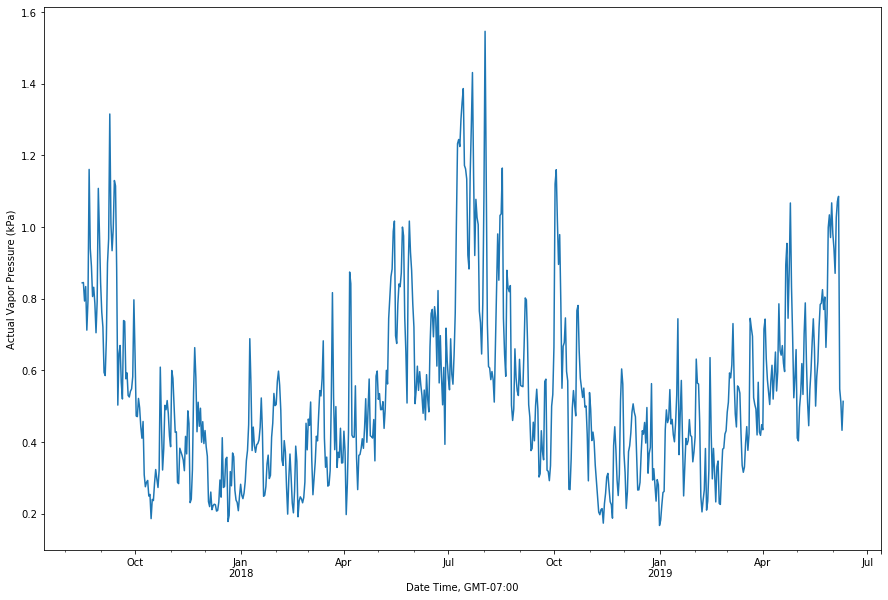

In [44]:
es_max = ugs_clim_raw.groupby(pd.Grouper(freq='1D'))['air_temp_c'].max().apply(lambda x: vsat(x),1)
es_min = ugs_clim_raw.groupby(pd.Grouper(freq='1D'))['air_temp_c'].min().apply(lambda x: vsat(x),1)
rh_min = ugs_clim_raw.groupby(pd.Grouper(freq='1D'))['RH'].min()
rh_max = ugs_clim_raw.groupby(pd.Grouper(freq='1D'))['RH'].max()

ea = ((es_max*rh_min/100)+(es_min*rh_max/100))/2
ea.plot()

ugs_clim_raw_dly['act_vap_press'] = ea
plt.ylabel('Actual Vapor Pressure (kPa)')

## Step 12 – The inverse relative distance Earth-Sun and Declination

In [45]:
ugs_clim_raw_dly['julian'] = ugs_clim_raw_dly.index.to_julian_date()

In [46]:
ugs_clim_raw_dly['julian'].tail()

Date Time, GMT-07:00
2019-06-06    2458640.5
2019-06-07    2458641.5
2019-06-08    2458642.5
2019-06-09    2458643.5
2019-06-10    2458644.5
Freq: D, Name: julian, dtype: float64

In [47]:
ugs_clim_raw_dly['dr'] = ugs_clim_raw_dly['julian'].apply(lambda x: 1 + 0.033*np.cos((2*np.pi/365.25*x)),1)
ugs_clim_raw_dly['declin'] = ugs_clim_raw_dly['julian'].apply(lambda x: 0.409*np.sin((2*np.pi/365.25*x)-1.39),1)

## Step 13 – Conversion of latitude

In [48]:
lat_rad = np.pi/180.0*39.559083

## Step 14 - Sunset hour angle

In [49]:
ugs_clim_raw_dly['sunst_hr'] = ugs_clim_raw_dly['declin'].apply(lambda x: np.arccos(-1*np.tan(lat_rad)*np.tan(x)),1)

## Step 15 – Extraterrestrial radiation

In [50]:
erc = 26*60/np.pi*0.0820
ugs_clim_raw_dly['extra_rad'] =  ugs_clim_raw_dly[['sunst_hr','dr','declin']].apply(lambda x: erc*x[1]*((x[0]*np.sin(lat_rad)*np.sin(x[2]))+(np.cos(lat_rad)*np.cos(x[2])*np.sin(x[0]))),1)

## Step 16 – Clear Sky Solar Radiation

In [51]:
ugs_clim_raw_dly['clear_rad'] = ugs_clim_raw_dly['extra_rad'].apply(lambda x: (0.75 + 0.00002 * 1461)*x,1)

## Step 17 – Net solar or net shortwave radiation

In [52]:
a=0.23
ugs_clim_raw_dly['rns'] = ugs_clim_raw_dly['solar_rad'].apply(lambda x: (1-a)*x,1)

## Step 18 – Net outgoing long wave solar radiation

In [53]:
def net_out_rad(df):
    pta = ((df['max_dly_temp']+273.16)**4+(df['min_dly_temp']+273.16)**4)/2
    ptb = 0.34-0.14*np.sqrt(df['act_vap_press'])
    ptc = 1.35*(df['solar_rad']/df['clear_rad'])-0.35
    omegs = 4.903E-9
    return omegs*pta*ptb*ptc

ugs_clim_raw_dly['net_out_rad'] = ugs_clim_raw_dly.apply(lambda df: net_out_rad(df),1)

## Step 19 – Net radiation

In [54]:
ugs_clim_raw_dly['net_rad'] = ugs_clim_raw_dly['rns'] - ugs_clim_raw_dly['net_out_rad']
ugs_clim_raw_dly['net_rad_g'] = ugs_clim_raw_dly['net_rad']*0.408

## FS1 - Radiation Term

In [55]:
ugs_clim_raw_dly['et_rad'] = ugs_clim_raw_dly['net_rad_g'] * ugs_clim_raw_dly['delta']

## FS2 - Wind Term

In [56]:
ugs_clim_raw_dly['et_wind'] = ugs_clim_raw_dly['psi']*ugs_clim_raw_dly['TT']*(ugs_clim_raw_dly['sat_vap_press']-ugs_clim_raw_dly['act_vap_press'])

## FINAL - Ref ET

In [57]:
#ugs_clim_raw_dly = pd.read_pickle(file_place + "ugs_clim_dly.pickle")

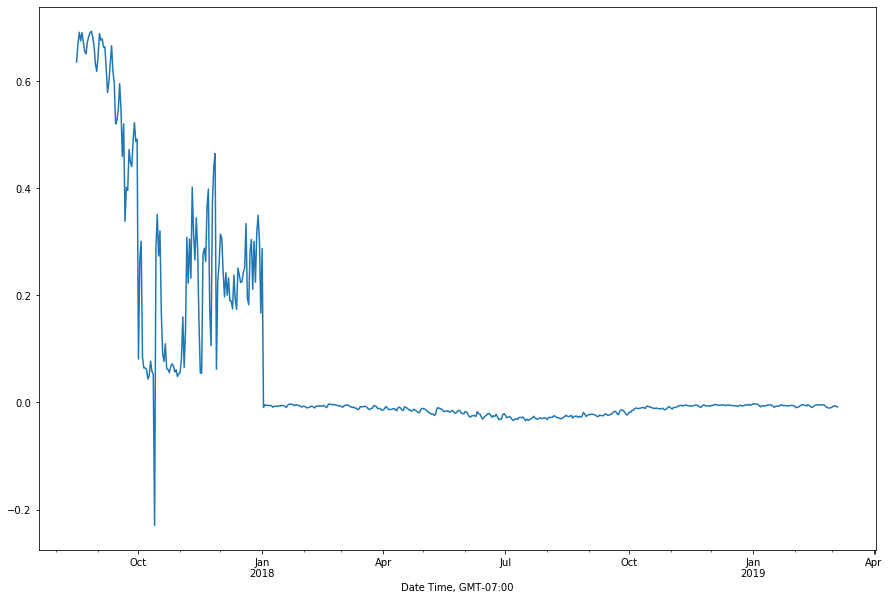

In [58]:
ugs_clim_raw_dly['et_ref'] = ugs_clim_raw_dly['et_rad'] + ugs_clim_raw_dly['et_wind']
ugs_clim_raw_dly['delta'].plot()

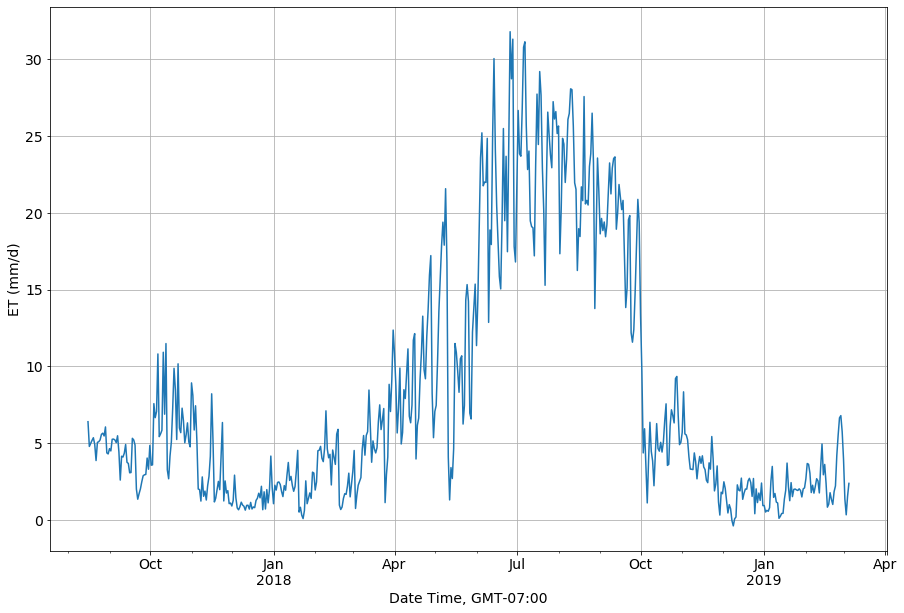

In [59]:
figplace= "G:/My Drive/WORK/Leland_Harris/figures/"
rcParams['figure.figsize'] = 15, 10
rcParams["font.size"] = 14
ugs_clim_raw_dly['et_ref'].plot()
plt.grid()
plt.ylabel('ET (mm/d)')
plt.savefig(figplace+"penman-monteith_et.png")
plt.savefig(figplace+"penman-monteith_et.svg")
plt.savefig(figplace+"penman-monteith_et.pdf")

In [60]:
ugs_clim_raw_dly.to_csv(file_place + "ugs_clim_dly.csv")
ugs_clim_raw_dly.to_pickle(file_place + "ugs_clim_dly.pickle")

In [61]:
ugs_clim_raw_dly.head()

,numb,DewPt,Gust_Speed,PAR1,PAR2,BaroPressure,RH,precip,SolarRadiation1,SolarRadiation2,...,sunst_hr,extra_rad,clear_rad,rns,net_out_rad,net_rad,net_rad_g,et_rad,et_wind,et_ref
"Date Time, GMT-07:00",,,,,,,,,,,,,,,,,,,,,
2017-08-16,14.5,41.982143,11.605357,666.378571,127.271429,25.250454,30.664286,0.0,338.207143,103.692857,...,1.835001,42.016379,32.740003,14.699362,3.459552,11.239810,4.585842,2.914161,3.483139,6.397301
2017-08-17,52.5,40.931250,7.425208,603.543750,116.616667,25.287892,35.468750,0.0,269.654167,85.410417,...,1.830577,41.863164,32.620614,11.810868,2.248417,9.562451,3.901480,2.612902,2.174203,4.787105
2017-08-18,100.5,39.139583,7.222917,602.450000,116.772917,25.298644,30.066667,0.0,302.618750,95.068750,...,1.826088,41.706663,32.498666,13.228677,2.967305,10.261372,4.186640,2.892462,2.098147,4.990609
2017-08-19,148.5,39.981250,9.602917,514.377083,98.543750,25.239212,29.560417,0.0,265.358333,82.097917,...,1.821535,41.546896,32.374172,11.557785,2.282297,9.275488,3.784399,2.553441,2.627715,5.181157
2017-08-20,196.5,37.070833,8.481458,602.658333,117.293750,25.211837,27.881250,0.0,301.104167,94.625000,...,1.816921,41.383879,32.247146,13.163535,3.083721,10.079814,4.112564,2.838210,2.516786,5.354995


In [62]:
ugs_clim_raw.to_csv(file_place + "ugs_clim.csv")
ugs_clim_raw.to_pickle(file_place + "ugs_clim.pickle")